In [1]:
## Import packages
import os
import mne
import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt

from scipy.signal import butter, sosfiltfilt, sosfreqz  
from scipy.io import loadmat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, roc_curve, auc

import scripts.classification_utils as utils
import scripts.CSP as csp
import scripts.SACSP as sacsp

In [2]:
## Define directories
data_dir = '/home/inffzy/Desktop/cogs189/cogs189_final_project/data'

In [3]:
## Raw data directory names
bc4_2a_processed_name = 'bci_competition_4_2a_processed'
bc3_3a_processed_name = 'bci_competition_3_3a_processed'

## Create list of all data paths
bc4_2a_processed_data_paths = []
bc3_3a_processed_data_paths = []

## Add bc4_2a data paths
for subject_idx in range(1, 10):
    subject_name = 'A0' + str(subject_idx) + 'T'
    bc4_2a_processed_data_paths.append(
        os.path.join(data_dir, bc4_2a_processed_name, subject_name + '.npz'))
    
## Add bc3_3a data paths
for subject_idx in range(1, 4):
    subject_name = 'bc3_3a_s' + str(subject_idx)
    bc3_3a_processed_data_paths.append(
        os.path.join(data_dir, bc3_3a_processed_name, subject_name + '.npz'))
    
all_data_paths = bc4_2a_processed_data_paths + bc3_3a_processed_data_paths

In [4]:
## Define constants
label_left_hand = 769
label_right_hand = 770
num_samples = 10
test_split = 0.33
random_state = 42
num_cross_val = 5

## Regular CSP Visualization

(138, 22, 500)
(138, 22)


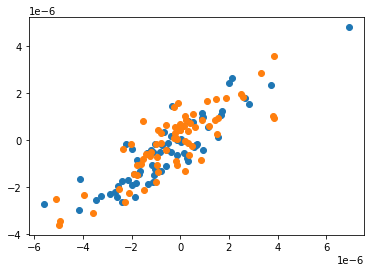

In [12]:
data_npz = np.load(all_data_paths[0])
data = data_npz['processed_motor_imagery_data']
labels = data_npz['descriptions']

## Extract left and right hand epochs
data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]

print(data.shape)

data_ds = np.mean(data, axis=-1)
print(data_ds.shape)

data_ds_c1 = data_ds[labels == label_left_hand]
data_ds_c2 = data_ds[labels == label_right_hand]

plt.scatter(data_ds_c1[:, 0], data_ds_c1[:, 1])
plt.scatter(data_ds_c2[:, 0], data_ds_c2[:, 1])

(138, 2, 500)
(138, 2)


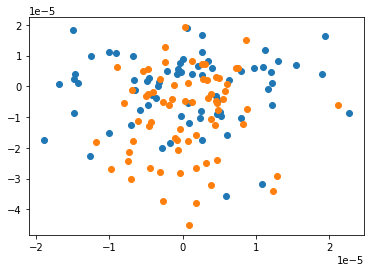

In [13]:
data_c1 = data[labels == label_left_hand]
data_c2 = data[labels == label_right_hand]
csp_transform = csp.CSP(data_c1, data_c2, n_top=1, n_bot=1)
data_ = csp.apply_CSP(csp_transform, data)

print(data_.shape)

data_ds = np.mean(data_, axis=-1)
print(data_ds.shape)

data_ds_c1 = data_ds[labels == label_left_hand]
data_ds_c2 = data_ds[labels == label_right_hand]

plt.scatter(data_ds_c1[:, 0], data_ds_c1[:, 1])
plt.scatter(data_ds_c2[:, 0], data_ds_c2[:, 1])

(138, 2, 500)
(138, 2)


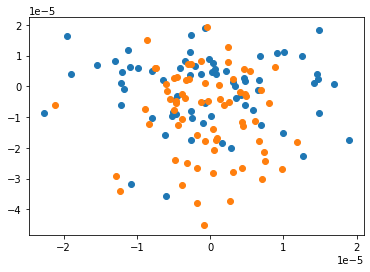

In [14]:
data_c1 = data[labels == label_left_hand]
data_c2 = data[labels == label_right_hand]
csp_transform = csp.CSP2(data_c1, data_c2, n_top=1, n_bot=1)
data_ = csp.apply_CSP(csp_transform, data)

print(data_.shape)

data_ds = np.mean(data_, axis=-1)
print(data_ds.shape)

data_ds_c1 = data_ds[labels == label_left_hand]
data_ds_c2 = data_ds[labels == label_right_hand]

plt.scatter(data_ds_c1[:, 0], data_ds_c1[:, 1])
plt.scatter(data_ds_c2[:, 0], data_ds_c2[:, 1])

## Binary Classification with LDA

In [8]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((len(all_data_paths), 3)) 

for i, data_path in enumerate(all_data_paths):
    
    ## Load data
    data_npz = np.load(data_path)
    data = data_npz['processed_motor_imagery_data']
    labels = data_npz['descriptions']
    
    ## Extract left and right hand epochs
    data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
    labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]

    ## Downsample with windowed means
    data_ds = utils.windowed_means(data, num_samples)
    
    ## Flatten data
    data_ds_flattened = utils.flatten_dim12(data_ds)
    
    ## Prepare training and testing data
    X_train, X_test, y_train, y_test = train_test_split(data_ds_flattened, 
                                                        labels, 
                                                        test_size=test_split, 
                                                        shuffle=True,
                                                        random_state=random_state)
    
    ## Classification
    clf = utils.LDA_classifier(X_train, y_train, cross_val=num_cross_val)
    cross_val_score_avg = clf.train_binary()
    predictions, train_accuracy = clf.test_binary()
    predictions, test_accuracy = clf.test_binary(X_test, y_test)
    results[i, :] = [train_accuracy, cross_val_score_avg, test_accuracy]
    print()
    
results_avg = np.mean(results, axis=0)

Cross validation score average:  0.543859649122807
Training accuracy:  0.8695652173913043
Testing accuracy:  0.5652173913043478

Cross validation score average:  0.527485380116959
Training accuracy:  0.8791208791208791
Testing accuracy:  0.35555555555555557

Cross validation score average:  0.4497076023391813
Training accuracy:  0.8571428571428571
Testing accuracy:  0.4782608695652174

Cross validation score average:  0.6313725490196078
Training accuracy:  0.8953488372093024
Testing accuracy:  0.4418604651162791

Cross validation score average:  0.4666666666666667
Training accuracy:  0.8372093023255814
Testing accuracy:  0.5116279069767442

Cross validation score average:  0.4933333333333333
Training accuracy:  0.9333333333333333
Testing accuracy:  0.5263157894736842

Cross validation score average:  0.47124183006535947
Training accuracy:  0.7752808988764045
Testing accuracy:  0.5

Cross validation score average:  0.4673202614379085
Training accuracy:  0.8863636363636364
Testing accura

In [9]:
print(results)
print(results_avg)

[[0.86956522 0.54385965 0.56521739]
 [0.87912088 0.52748538 0.35555556]
 [0.85714286 0.4497076  0.47826087]
 [0.89534884 0.63137255 0.44186047]
 [0.8372093  0.46666667 0.51162791]
 [0.93333333 0.49333333 0.52631579]
 [0.7752809  0.47124183 0.5       ]
 [0.88636364 0.46732026 0.54545455]
 [0.94805195 0.49166667 0.43589744]
 [1.         0.62222222 0.28      ]
 [1.         0.61428571 0.5625    ]
 [1.         0.48       0.5       ]]
[0.90678474 0.52159682 0.47522416]


## Binary Classification with Regular CSP + LDA

In [10]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((len(all_data_paths), 3)) 

for i, data_path in enumerate(all_data_paths):
    
    ## Load data
    data_npz = np.load(data_path)
    data = data_npz['processed_motor_imagery_data']
    labels = data_npz['descriptions']
    
    ## Extract left and right hand epochs
    data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
    labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
    
    ## Prepare training and testing data
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                        labels, 
                                                        test_size=test_split, 
                                                        shuffle=True,
                                                        random_state=random_state)
    
    ## Classification
    clf = csp.CSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val, num_samples=num_samples)
    cross_val_score_avg = clf.train_binary()
    predictions, train_accuracy = clf.test_binary()
    predictions, test_accuracy = clf.test_binary(X_test, y_test)
    results[i, :] = [train_accuracy, cross_val_score_avg, test_accuracy]
    print()

results_avg = np.mean(results, axis=0)

Cross validation score average:  0.5666666666666667
Training accuracy:  0.75
Testing accuracy:  0.5434782608695652

Cross validation score average:  0.41812865497076024
Training accuracy:  0.6483516483516484
Testing accuracy:  0.37777777777777777

Cross validation score average:  0.5935672514619883
Training accuracy:  0.7582417582417582
Testing accuracy:  0.6086956521739131

Cross validation score average:  0.4666666666666667
Training accuracy:  0.6976744186046512
Testing accuracy:  0.4186046511627907

Cross validation score average:  0.5830065359477123
Training accuracy:  0.6744186046511628
Testing accuracy:  0.32558139534883723

Cross validation score average:  0.5733333333333334
Training accuracy:  0.8
Testing accuracy:  0.39473684210526316

Cross validation score average:  0.5058823529411764
Training accuracy:  0.6853932584269663
Testing accuracy:  0.5909090909090909

Cross validation score average:  0.5019607843137255
Training accuracy:  0.7840909090909091
Testing accuracy:  0.431

In [11]:
print(results)
print(results_avg)

[[0.75       0.56666667 0.54347826]
 [0.64835165 0.41812865 0.37777778]
 [0.75824176 0.59356725 0.60869565]
 [0.69767442 0.46666667 0.41860465]
 [0.6744186  0.58300654 0.3255814 ]
 [0.8        0.57333333 0.39473684]
 [0.68539326 0.50588235 0.59090909]
 [0.78409091 0.50196078 0.43181818]
 [0.8961039  0.44333333 0.41025641]
 [0.89583333 0.54       0.36      ]
 [0.96774194 0.32380952 0.6875    ]
 [1.         0.52       0.35714286]]
[0.79648748 0.50302959 0.45887509]


## Binary Classification with Spectrally Adaptive CSP + LDA

In [ ]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((len(all_data_paths), 3)) 

for i, data_path in enumerate(all_data_paths):
    
    ## Load data
    data_npz = np.load(data_path)
    data = data_npz['processed_motor_imagery_data']
    labels = data_npz['descriptions']
    
    ## Extract left and right hand epochs
    data = data[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
    labels = labels[np.any([labels == label_left_hand, labels == label_right_hand], axis=0)]
    
    ## Prepare training and testing data
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                        labels, 
                                                        test_size=test_split, 
                                                        shuffle=True,
                                                        random_state=random_state)
    
    ## Classification
    clf = sacsp.SACSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val)
    cross_val_score_avg = clf.train_binary()
    predictions, train_accuracy = clf.test_binary()
    predictions, test_accuracy = clf.test_binary(X_test, y_test)
    results[i, :] = [train_accuracy, cross_val_score_avg, test_accuracy]
    print()
    
results_avg = np.mean(results, axis=0)

In [ ]:
print(results)
print(results_avg)

## 4-Class One-vs-One Classification with LDA

In [ ]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((len(all_data_paths), 3)) 

for i, data_path in enumerate(all_data_paths):
    
    ## Load data
    data_npz = np.load(data_path)
    data = data_npz['processed_motor_imagery_data']
    labels = data_npz['descriptions']

    ## Downsample with windowed means
    data_ds = utils.windowed_means(data, num_samples)
    
    ## Flatten data
    data_ds_flattened = utils.flatten_dim12(data_ds)
    
    ## Prepare training and testing data
    X_train, X_test, y_train, y_test = train_test_split(data_ds_flattened, 
                                                        labels, 
                                                        test_size=test_split, 
                                                        shuffle=True,
                                                        random_state=random_state)
    
    ## Classification
    clf = utils.LDA_classifier(X_train, y_train, cross_val=num_cross_val)
    cross_val_scores = clf.train_1_vs_1()
    predictions, train_accuracy = clf.test_1_vs_1()
    predictions, test_accuracy = clf.test_1_vs_1(X_test, y_test)
    results[i, :] = [train_accuracy, np.mean(cross_val_scores), test_accuracy]
    print()
    
results_avg = np.mean(results, axis=0)

In [ ]:
print(results)
print(results_avg)

## 4-Class One-vs-One Classification with Regular CSP + LDA

In [ ]:
## results records training accuracy, cross validation average score, and testing accuracy for each subject
results = np.zeros((len(all_data_paths), 3)) 

for i, data_path in enumerate(all_data_paths):
    
    ## Load data
    data_npz = np.load(data_path)
    data = data_npz['processed_motor_imagery_data']
    labels = data_npz['descriptions']
    
    ## Prepare training and testing data
    X_train, X_test, y_train, y_test = train_test_split(data, 
                                                        labels, 
                                                        test_size=test_split, 
                                                        shuffle=True,
                                                        random_state=random_state)
    
    ## Classification
    clf = csp.CSP_LDA_classifier(X_train, y_train, cross_val=num_cross_val, num_samples=num_samples)
    cross_val_scores = clf.train_1_vs_1()
    predictions, train_accuracy = clf.test_1_vs_1()
    predictions, test_accuracy = clf.test_1_vs_1(X_test, y_test)
    results[i, :] = [train_accuracy, np.mean(cross_val_scores), test_accuracy]
    print()
    
results_avg = np.mean(results, axis=0)

In [ ]:
print(results)
print(results_avg)

## 4-Class One-vs-One Classification with Spectrally Adaptive CSP + LDA

In [ ]:
def SACSP2_Eq_4_or_5(data_fourier, h_or_l, w_or_v, avg_cov_sum):
    
    numerator = (w_or_v.T @ data_fourier @ np.diag(h_or_l) @ np.matrix(data_fourier).H @ w_or_v)[0, 0]
    denominator = (w_or_v.T @ avg_cov_sum @ w_or_v)[0, 0]
    
    return numerator / denominator

In [ ]:
def SACSP2_Eq_6_or_7(data_fourier, h_or_l, avg_cov_sum, top_n):
    E = data_fourier @ np.diag(h_or_l) @ np.matrix(data_fourier).H
    
    ## Generalized eigen-decomposition of Eq6 and Eq7 along with sum of class' spatial covariances
    eigval, eigvec = sp.linalg.eigh(E, avg_cov_sum)
    
    ## Extract top n eigen vectors
    sort_indices = np.argsort(eigval)
    top_n_indices = list(sort_indices[-top_n:])
    top_n_eigvec = eigvec[:, top_n_indices]
    
    return top_n_eigvec

In [ ]:
def SACSP2(c1_data, c2_data, R=3, M=1, e=1e-6):
    
    ## R = number of spectral/spatial filters for each class
    ## M = number of initializations of spectral filters
    
    t = c1_data.shape[-1]  ## Number of time samples
    F = sp.linalg.dft(t)  ## Fourier matrix with shape t x t
    
    H = np.ones((M, t))  ## Initialize M number of h vectors
    L = np.ones((M, t))  ## Initialize M number of l vectors
 
    c1_data_avg = np.mean(c1_data, axis=0)
    c2_data_avg = np.mean(c2_data, axis=0)

    c1_data_avg_cov = np.cov(c1_data_avg)
    c2_data_avg_cov = np.cov(c2_data_avg)
    avg_cov_sum = c1_data_avg_cov + c2_data_avg_cov
    
    c1_data_avg_fourier = c1_data_avg @ F
    c2_data_avg_fourier = c2_data_avg @ F
    
    c1_filter_pairs = []
    c2_filter_pairs = []
    
    for m in range(M):
        
        ## h and l are spectral filters
        h = H[m, :]
        l = L[m, :]
        
        ## w and v are spatial filters
        W = SACSP_Eq_6_or_7(c1_data_avg_fourier, h, avg_cov_sum, top_n=R)
        V = SACSP_Eq_6_or_7(c2_data_avg_fourier, l, avg_cov_sum, top_n=R)
        
        for r in range(R):  
            
            ### Class 1 optimization ###
            
            w = np.atleast_2d(W[:, r]).T  ## From W, get w as a column vector
            
            c1_cost = 0
            c1_cost_increase = e + 1
            
            while c1_cost_increase > e:
            
                ## Update spectral filter h_r_m from Eq9    
                E = np.matrix(c1_data_avg_fourier).H @ w @ w.T @ c1_data_avg_fourier
                
                for k in range(t):
                    h[k] = E[k, k] / np.linalg.norm(np.diag(E))
                
                H[m, :] = h
                
                ## Update spatial filter w_r by selecting the eigenvector 
                ##   corresponding to the largest eigenvalue from Eq6
                w = SACSP_Eq_6_or_7(c1_data_avg_fourier, h, avg_cov_sum, top_n=1)
                W[:, r] = w.flatten()

                ## Calculate cost
                c1_cost_prev = c1_cost
                c1_cost = SACSP_Eq_4_or_5(c1_data_avg_fourier, h, w, avg_cov_sum)
                c1_cost_increase = c1_cost - c1_cost_prev
   
            c1_filter_pairs.append([h, w])
            
            
            ### Class 2 optimization ###
            
            v = np.atleast_2d(V[:, r]).T  ## From V, get v as a column vector
            
            c2_cost = 0
            c2_cost_increase = e + 1
            
            while c2_cost_increase > e:
            
                ## Update spectral filter l_r_m from Eq10    
                E = np.matrix(c2_data_avg_fourier).H @ v @ v.T @ c2_data_avg_fourier
                
                for k in range(t):
                    l[k] = E[k, k] / np.linalg.norm(np.diag(E))
                
                L[m, :] = l
                
                ## Update spatial filter v_r by selecting the eigenvector 
                ##   corresponding to the largest eigenvalue from Eq7
                v = SACSP_Eq_6_or_7(c2_data_avg_fourier, l, avg_cov_sum, top_n=1)
                V[:, r] = v.flatten()

                ## Calculate cost
                c2_cost_prev = c2_cost
                c2_cost = SACSP_Eq_4_or_5(c2_data_avg_fourier, l, v, avg_cov_sum)
                c2_cost_increase = c2_cost - c2_cost_prev

            c2_filter_pairs.append([l, v])
    
    ## From the M x R pairs of spatial and spectral filters, select R pairs that maximize the cost function
    
    
    
    
    return c1_filter_pairs, c2_filter_pairs